In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
%matplotlib qt

In [7]:
from PIL import Image
import os
from io import BytesIO
from keras.preprocessing import image
import cv2
import hashlib
import numpy

In [3]:
def split_88(image_data):
    blocks = []
    image_size = image_data.shape[0]
    for i in range(int(image_size / 8)):
        row = image_data[8*i:8*(i+1), :]
        for j in range(int(image_size / 8)):
            col = row[:, 8*j:8*(j+1)]
            blocks.append(col.astype(float32))
    return array(blocks)

def merge_88(blocks):
    block_count = blocks.shape[0]
    edge_len = int(sqrt(block_count))
    img_size = 8*edge_len
    image_rows = []
    for i in range(edge_len):
        img_row = hstack(blocks[edge_len*i: edge_len*(i+1), ...])
        image_rows.append(img_row)
    return vstack(image_rows)

def split_1616(image_data):
    blocks = []
    image_size = image_data.shape[0]
    for i in range(int(image_size / 16)):
        row = image_data[16*i:16*(i+1), :]
        for j in range(int(image_size / 16)):
            col = row[:, 16*j:16*(j+1)]
            blocks.append(col.astype(float32))
    return array(blocks)

def merge_1616(blocks):
    block_count = blocks.shape[0]
    edge_len = int(sqrt(block_count))
    img_size = 16*edge_len
    image_rows = []
    for i in range(edge_len):
        img_row = hstack(blocks[edge_len*i: edge_len*(i+1), ...])
        image_rows.append(img_row)
    return vstack(image_rows)

def zig_zag_flatten(a):
    return np.concatenate([np.diagonal(a[::-1,:], i)[::(2*(i % 2)-1)] for i in range(1-a.shape[0], a.shape[0])])

def file_size(image, quality):
    f = BytesIO()
    image.save(f, format='JPEG', quality = quality)
    file_size = len(f.getvalue())
    return file_size

In [4]:
def image_generator(images_dir, target_size=None):
    count = 0
    while True:
        print("Data round %s" % count)
        for filename in os.listdir(images_dir):
            img = Image.open("%s/%s" % (images_dir, filename))
            print("%s/%s" % (images_dir, filename))
            if target_size is not None:
                img = img.resize(target_size)
#             img = image.load_img('%s/%s' % (images_dir, filename), target_size=target_size)

            f = BytesIO()
            img.save(f, format='JPEG', quality=100)
            bytes_content = f.getvalue()
            origin_file_size = len(bytes_content)
            yield img, origin_file_size
        count += 1
        
def simple_image_generator(images_dir):
    count = 0
    while True:
        print("Data round %s" % count)
        for filename in os.listdir(images_dir):
            img = Image.open("%s/%s" % (images_dir, filename))
            yield img
        count += 1

In [4]:
generator = simple_image_generator('/home/imagenet-data/train/n03085013')

In [5]:
generator = image_generator('/home/imagenet-data/train/n03085013')

In [6]:
# Generate testing image
for i in range(3):
    print(i)
    origin_image, origin_image_size= next(generator)
    print(origin_image_size)
    origin_image


0
Data round 0
/home/imagenet-data/train/n03085013/n03085013_4489.JPEG
166425
1
/home/imagenet-data/train/n03085013/n03085013_25671.JPEG
167030
2
/home/imagenet-data/train/n03085013/n03085013_20716.JPEG
122202


122202


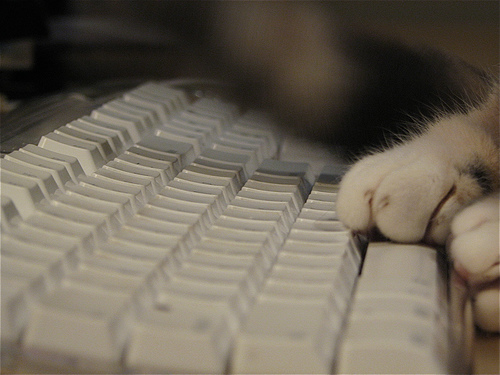

In [7]:
print(origin_image_size)
origin_image

In [8]:
origin_image, origin_image_size= next(generator)

/home/imagenet-data/train/n03085013/n03085013_9533.JPEG


/home/imagenet-data/train/n03085013/n03085013_5738.JPEG
199518


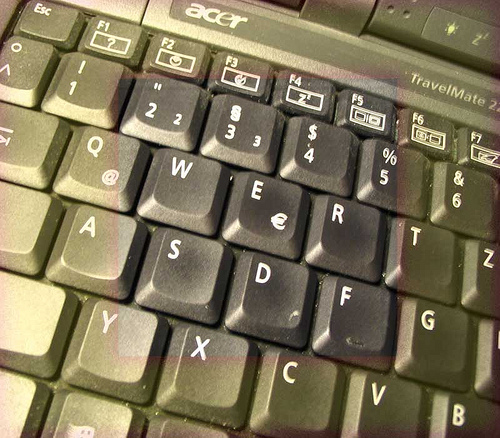

In [9]:
origin_image, origin_image_size= next(generator)
print(origin_image_size)
origin_image

In [10]:
print(origin_image_size)

199518


# DeepN-JPEG

#### 初始化

In [88]:
from numpy import *
import numpy as np
from PIL import Image
import os
from io import BytesIO
from keras.preprocessing import image
import cv2
import hashlib
import time
import matplotlib.pyplot as plt
import base64

In [89]:
def split_88(image_data):
    blocks = []
    image_size = min(image_data.shape)
    for i in range(int(image_size / 8)):
        row = image_data[8*i:8*(i+1), :]
        for j in range(int(image_size / 8)):
            col = row[:, 8*j:8*(j+1)]
            blocks.append(col.astype(float32))
    return array(blocks)

def merge_88(blocks):
    block_count = blocks.shape[0]
    edge_len = int(sqrt(block_count))
    img_size = 8*edge_len
    image_rows = []
    for i in range(edge_len):
        img_row = hstack(blocks[edge_len*i: edge_len*(i+1), ...])
        image_rows.append(img_row)
    return vstack(image_rows)

def split_1616(image_data):
    blocks = []
    image_size = image_data.shape[0]
    for i in range(int(image_size / 16)):
        row = image_data[16*i:16*(i+1), :]
        for j in range(int(image_size / 16)):
            col = row[:, 16*j:16*(j+1)]
            blocks.append(col.astype(float32))
    return array(blocks)

def merge_1616(blocks):
    block_count = blocks.shape[0]
    edge_len = int(sqrt(block_count))
    img_size = 16*edge_len
    image_rows = []
    for i in range(edge_len):
        img_row = hstack(blocks[edge_len*i: edge_len*(i+1), ...])
        image_rows.append(img_row)
    return vstack(image_rows)

def zig_zag_flatten(a):
    return np.concatenate([np.diagonal(a[::-1,:], i)[::(2*(i % 2)-1)] for i in range(1-a.shape[0], a.shape[0])])

def file_size(image, quality):
    f = BytesIO()
    image.save(f, format='JPEG', quality = quality)
    file_size = len(f.getvalue())
    return file_size

#### 拆分过程分析

In [167]:
origin_image = Image.open('/home/imagenet-data/train/n03085013/n03085013_21081.JPEG')

In [5]:
origin_image = Image.open('/home/imagenet-data/train//n07802026/n07802026_4094.JPEG' )

(500, 374)


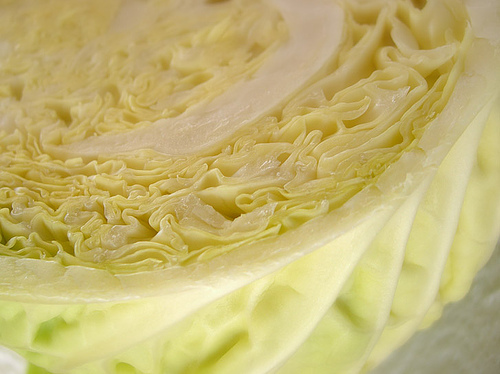

In [42]:
import numpy as np
origin_image = Image.open('/home/imagenet-data/train//n07714571/n07714571_9793.JPEG' )
print(np.size(origin_image))
origin_image

In [43]:
img_yuv = origin_image.convert('YCbCr')

In [44]:
print(img_yuv)

<PIL.Image.Image image mode=YCbCr size=500x374 at 0x7FCEE18B16A0>


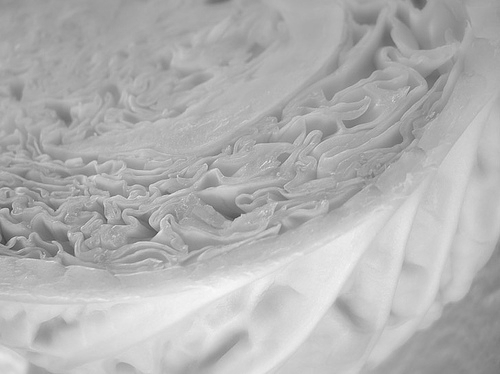

In [45]:
channels = img_yuv.split()
channels[0]

In [60]:
def split_88(image_data):
    blocks = []
    image_size = min(image_data.shape)
    for i in range(int(image_size / 8)):
        row = image_data[8*i:8*(i+1), :]
        for j in range(int(image_size / 8)):
            col = row[:, 8*j:8*(j+1)]
            blocks.append(col.astype(float32))
    return array(blocks)
channel = channels[0]
image_data = np.asarray(channel)
print(image_data.shape[0])
print(image_data.shape[1])
print("min:",min(image_data.shape[0],image_data.shape[1]))
#print(size(image_data))

374
500
min: 374


In [53]:
channel = channels[0]
image_data = np.asarray(channel)
print("image_data",image_data)
print("image_data.shape",image_data.shape)
image_size = min(image_data.shape)
int(image_size / 8)
blocks = []
for i in range(int(image_size / 8)):
    row = image_data[8*i:8*(i+1), :]
    for j in range(int(image_size / 8)):
        col = row[:, 8*j:8*(j+1)]
        blocks.append(col.astype(float32))
blocks = array(blocks)        
print("blocks",blocks)
print("blocks.shape",blocks.shape)

image_data [[145 146 147 ... 155 155 155]
 [145 146 147 ... 157 157 156]
 [145 146 147 ... 157 155 156]
 ...
 [207 205 204 ... 124 125 125]
 [208 207 206 ... 123 123 123]
 [209 208 208 ... 123 122 121]]
image_data.shape (374, 500)
blocks [[[145. 146. 147. ... 150. 150. 150.]
  [145. 146. 147. ... 149. 150. 149.]
  [145. 146. 147. ... 149. 148. 147.]
  ...
  [145. 145. 146. ... 147. 146. 146.]
  [145. 145. 145. ... 147. 147. 147.]
  [147. 147. 147. ... 148. 150. 150.]]

 [[149. 149. 150. ... 147. 145. 144.]
  [149. 149. 149. ... 146. 145. 145.]
  [145. 146. 146. ... 144. 146. 146.]
  ...
  [146. 146. 147. ... 147. 148. 149.]
  [147. 147. 147. ... 148. 148. 148.]
  [150. 150. 150. ... 148. 149. 149.]]

 [[146. 146. 146. ... 150. 149. 151.]
  [146. 146. 147. ... 149. 150. 152.]
  [146. 147. 147. ... 150. 150. 152.]
  ...
  [149. 148. 146. ... 149. 151. 152.]
  [150. 147. 147. ... 151. 153. 154.]
  [150. 148. 147. ... 153. 154. 154.]]

 ...

 [[192. 192. 192. ... 192. 190. 190.]
  [191. 19

In [103]:
channel = channels[0]
image_data = np.asarray(channel)
print("image_data",image_data)
print("image_data.shape",image_data.shape)
image_size = min(image_data.shape)
int(image_size / 8)
blocks = []
for i in range(int(image_data.shape[0] / 8)):
    row = image_data[8*i:8*(i+1), :]
    for j in range(int(image_data.shape[1] / 8)):
        col = row[:, 8*j:8*(j+1)]
        blocks.append(col.astype(float32))
blocks = array(blocks)-128        
print("blocks",blocks)
print("blocks.shape",blocks.shape)

image_data [[145 146 147 ... 155 155 155]
 [145 146 147 ... 157 157 156]
 [145 146 147 ... 157 155 156]
 ...
 [207 205 204 ... 124 125 125]
 [208 207 206 ... 123 123 123]
 [209 208 208 ... 123 122 121]]
image_data.shape (374, 500)
blocks [[[17. 18. 19. ... 22. 22. 22.]
  [17. 18. 19. ... 21. 22. 21.]
  [17. 18. 19. ... 21. 20. 19.]
  ...
  [17. 17. 18. ... 19. 18. 18.]
  [17. 17. 17. ... 19. 19. 19.]
  [19. 19. 19. ... 20. 22. 22.]]

 [[21. 21. 22. ... 19. 17. 16.]
  [21. 21. 21. ... 18. 17. 17.]
  [17. 18. 18. ... 16. 18. 18.]
  ...
  [18. 18. 19. ... 19. 20. 21.]
  [19. 19. 19. ... 20. 20. 20.]
  [22. 22. 22. ... 20. 21. 21.]]

 [[18. 18. 18. ... 22. 21. 23.]
  [18. 18. 19. ... 21. 22. 24.]
  [18. 19. 19. ... 22. 22. 24.]
  ...
  [21. 20. 18. ... 21. 23. 24.]
  [22. 19. 19. ... 23. 25. 26.]
  [22. 20. 19. ... 25. 26. 26.]]

 ...

 [[12. 12. 14. ... 14. 12. 11.]
  [15. 14. 15. ... 13. 10. 11.]
  [15. 16. 15. ... 10. 10. 11.]
  ...
  [13. 13. 12. ...  8.  9.  9.]
  [13. 13. 13. ...  7.

In [58]:
print(blocks[2115])

[[196. 197. 194. 194. 194. 192. 191. 194.]
 [198. 197. 195. 196. 195. 189. 186. 190.]
 [197. 196. 196. 197. 194. 188. 185. 188.]
 [197. 197. 197. 195. 190. 185. 183. 185.]
 [198. 198. 196. 189. 182. 180. 180. 179.]
 [198. 197. 193. 184. 178. 178. 180. 178.]
 [196. 192. 187. 181. 176. 177. 182. 181.]
 [193. 188. 182. 178. 175. 177. 181. 180.]]


In [63]:
blocks = split_88(asarray(channel)) - 128
print(blocks[2115]+128)

[[196. 197. 194. 194. 194. 192. 191. 194.]
 [198. 197. 195. 196. 195. 189. 186. 190.]
 [197. 196. 196. 197. 194. 188. 185. 188.]
 [197. 197. 197. 195. 190. 185. 183. 185.]
 [198. 198. 196. 189. 182. 180. 180. 179.]
 [198. 197. 193. 184. 178. 178. 180. 178.]
 [196. 192. 187. 181. 176. 177. 182. 181.]
 [193. 188. 182. 178. 175. 177. 181. 180.]]


In [74]:
dct_blocks = array([cv2.dct(item) for item in blocks])
print("dct_blocks\n",dct_blocks[2115])
std_matrix = zeros([8, 8])
for i in range(8):
    for j in range(8):
        std_matrix[i, j] = std(dct_blocks[:,i,j], ddof=1)
print('std_matrix\n',std_matrix)

dct_blocks
 [[ 4.8625000e+02  3.9110077e+01  9.7896070e+00 -4.6138158e+00
   1.2500000e+00  2.8864810e-01 -5.3721321e-01 -1.7669852e-01]
 [ 3.4200901e+01 -8.7171040e+00 -1.3645242e+01 -9.6058249e-01
   5.8338418e+00 -4.5640230e+00  5.1026911e-01 -8.1489313e-01]
 [-4.6918550e+00 -1.1921496e+01  6.1302042e+00  4.1651282e+00
   9.6350777e-01 -4.5505092e-01 -1.0821067e+00 -2.9228422e-01]
 [-3.3521220e-01  4.3011909e+00  3.8911269e+00 -1.0445931e+00
  -4.3912020e+00  6.7790262e-02 -1.5892360e-01  3.1210390e-01]
 [-1.0000000e+00 -2.0210650e+00  0.0000000e+00 -5.0437171e-02
  -1.0000000e+00 -3.3701029e-02  1.9469306e-08 -4.0201491e-01]
 [ 2.6600330e+00 -3.3602011e+00  3.9164650e-01 -6.0898638e-01
   1.5625644e-01  3.6045700e-01 -1.7937352e-01 -2.2032408e-02]
 [-2.2135450e-01 -5.5996937e-01 -3.3210695e-01  3.9688084e-01
  -9.4029415e-01 -9.9741414e-02  1.1979623e-01 -7.7912576e-02]
 [-4.8502585e-01 -4.9166971e-01  4.3293688e-01 -1.1275358e-01
  -1.8497179e-01  5.8751458e-01 -8.8689573e-02 -9.8

In [75]:
rec_channels = []
q_tables = []
# Build Q-table
q_table = zeros([8, 8], dtype=int64)
a = 255
b = 80
c = 240
T1 = 20
T2 = 60
k1 = 9.75
k2 = 1
k3 = 3
Qmin = 5
for i in range(8):
    for j in range(8):
        std_value = std_matrix[i, j]
        if std_value <= T1:
            q = a - k1 * std_value
        elif std_value > T2:
            q = c - k3 * std_value
        else:
            q = b - k2 * std_value
        q = (q if (q > Qmin) else Qmin)
        q_table[i, j] = q

q_tables.append(q_table)
print("q_table",q_table)
print("q_tables",q_tables)

q_table [[  5  52 128 177 194 212 221 231]
 [ 42  71 147 187 203 212 221 233]
 [ 58 120 158 188 201 215 221 232]
 [120 152 173 196 205 215 226 233]
 [161 172 186 198 206 218 224 236]
 [186 193 199 205 211 219 228 238]
 [201 206 209 214 220 223 232 239]
 [218 221 222 222 227 233 239 244]]
q_tables [array([[  5,  52, 128, 177, 194, 212, 221, 231],
       [ 42,  71, 147, 187, 203, 212, 221, 233],
       [ 58, 120, 158, 188, 201, 215, 221, 232],
       [120, 152, 173, 196, 205, 215, 226, 233],
       [161, 172, 186, 198, 206, 218, 224, 236],
       [186, 193, 199, 205, 211, 219, 228, 238],
       [201, 206, 209, 214, 220, 223, 232, 239],
       [218, 221, 222, 222, 227, 233, 239, 244]])]


In [76]:
rec_channels = []
q_tables = []
for channel in channels:
    # split and shift
    blocks = split_88(asarray(channel)) - 128
    # dct and get std_matrix
    dct_blocks = array([cv2.dct(item) for item in blocks])
    std_matrix = zeros([8, 8])
    for i in range(8):
        for j in range(8):
            std_matrix[i, j] = std(dct_blocks[:,i,j], ddof=1)

    # Build Q-table
    q_table = zeros([8, 8], dtype=int64)
    a = 255
    b = 80
    c = 240
    T1 = 20
    T2 = 60
    k1 = 9.75
    k2 = 1
    k3 = 3
    Qmin = 5
    for i in range(8):
        for j in range(8):
            std_value = std_matrix[i, j]
            if std_value <= T1:
                q = a - k1 * std_value
            elif std_value > T2:
                q = c - k3 * std_value
            else:
                q = b - k2 * std_value
            q = (q if (q > Qmin) else Qmin)
            q_table[i, j] = q
    
    q_tables.append(q_table)

    # quantization by q-table and recovery from q-table
    quantizd_dct_blocks = np.round(array([block / q_table for block in dct_blocks]))
    rec_dct_blocks = array([block * q_table for block in quantizd_dct_blocks])
    # idct, round and shift
    idct_rec_blocks = np.round(array([cv2.idct(block) for block in rec_dct_blocks])) + 128
    # merge into an image
    rec_channel = merge_88(idct_rec_blocks)
    
    rec_channels.append(clip(rec_channel, 0, 255))

rec_channels = array(rec_channels, dtype=uint8)


q_tables [array([[  5,  51, 132, 182, 199, 215, 224, 233],
       [ 45,  83, 151, 190, 206, 215, 224, 234],
       [ 63, 131, 164, 191, 205, 217, 224, 233],
       [135, 163, 181, 200, 207, 217, 228, 235],
       [172, 181, 193, 203, 209, 219, 226, 237],
       [194, 200, 205, 209, 214, 222, 230, 240],
       [207, 212, 214, 218, 224, 226, 234, 240],
       [222, 225, 226, 226, 230, 235, 240, 244]]), array([[  5,  51, 132, 182, 199, 215, 224, 233],
       [ 45,  83, 151, 190, 206, 215, 224, 234],
       [ 63, 131, 164, 191, 205, 217, 224, 233],
       [135, 163, 181, 200, 207, 217, 228, 235],
       [172, 181, 193, 203, 209, 219, 226, 237],
       [194, 200, 205, 209, 214, 222, 230, 240],
       [207, 212, 214, 218, 224, 226, 234, 240],
       [222, 225, 226, 226, 230, 235, 240, 244]]), array([[  5,  51, 132, 182, 199, 215, 224, 233],
       [ 45,  83, 151, 190, 206, 215, 224, 234],
       [ 63, 131, 164, 191, 205, 217, 224, 233],
       [135, 163, 181, 200, 207, 217, 228, 235],
      

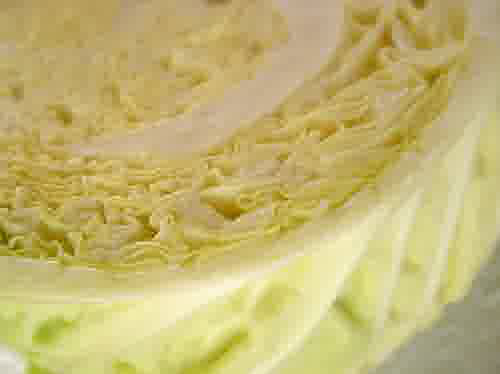

In [104]:
# def merge_88(blocks):
#     block_count = blocks.shape[0]
#     edge_len = int(sqrt(block_count))
#     img_size = 8*edge_len
#     image_rows = []
#     for i in range(edge_len):
#         img_row = hstack(blocks[edge_len*i: edge_len*(i+1), ...])
#         image_rows.append(img_row)
#     return vstack(image_rows)

rec_channels = []
q_tables = []
for channel in channels:
    # split and shift
#     blocks = split_88(asarray(channel)) - 128
    # dct and get std_matrix
    dct_blocks = array([cv2.dct(item) for item in blocks])
    std_matrix = zeros([8, 8])
    for i in range(8):
        for j in range(8):
            std_matrix[i, j] = std(dct_blocks[:,i,j], ddof=1)

    # Build Q-table
    q_table = zeros([8, 8], dtype=int64)
    a = 255
    b = 80
    c = 240
    T1 = 20
    T2 = 60
    k1 = 9.75
    k2 = 1
    k3 = 3
    Qmin = 5
    for i in range(8):
        for j in range(8):
            std_value = std_matrix[i, j]
            if std_value <= T1:
                q = a - k1 * std_value
            elif std_value > T2:
                q = c - k3 * std_value
            else:
                q = b - k2 * std_value
            q = (q if (q > Qmin) else Qmin)
            q_table[i, j] = q
    
    q_tables.append(q_table)

#     # quantization by q-table and recovery from q-table
#     quantizd_dct_blocks = np.round(array([block / q_table for block in dct_blocks]))
#     rec_dct_blocks = array([block * q_table for block in quantizd_dct_blocks])
#     # idct, round and shift
#     idct_rec_blocks = np.round(array([cv2.idct(block) for block in rec_dct_blocks])) + 128
#     # merge into an image
#     rec_channel = merge_88(idct_rec_blocks)
    
#     rec_channels.append(clip(rec_channel, 0, 255))

# rec_channels = array(rec_channels, dtype=uint8)
# pil_channels = [Image.fromarray(channel) for channel in rec_channels]
# rec_pil_image = Image.merge("YCbCr", pil_channels).convert('RGB')
# print(rec_pil_image.size)
# print(size(origin_image))
# image_size = size(rec_pil_image)[0]
# cropped_image = origin_image.crop((0, 0, image_size, image_size))
# print(size(cropped_image))
# rec_pil_image
print("q_tables",q_tables)
pil_qtables = {}
for idx, q_table in enumerate(q_tables):
    pil_qtables[idx] = zig_zag_flatten(q_table).tolist()
print("pil_qtables",pil_qtables)

f = BytesIO()
origin_image.save(f, format='JPEG', qtables=pil_qtables)
deepn_file_size = len(f.getvalue())
print(deepn_file_size)
f.seek(0)
deepn_image = Image.open(f)
deepn_image

In [77]:
pil_channels = [Image.fromarray(channel) for channel in rec_channels]

(368, 368)
(500, 374)
(368, 368)


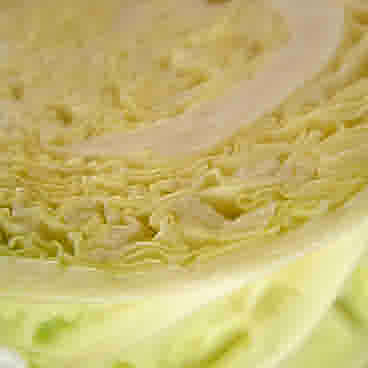

In [83]:
rec_pil_image = Image.merge("YCbCr", pil_channels).convert('RGB')
print(rec_pil_image.size)
print(size(origin_image))
image_size = size(rec_pil_image)[0]
cropped_image = origin_image.crop((0, 0, image_size, image_size))
print(size(cropped_image))
rec_pil_image

In [96]:
print(file_size(rec_pil_image, 75)) 
print(file_size(origin_image, 75))
print(file_size(cropped_image, 75))

7584
22634
17367


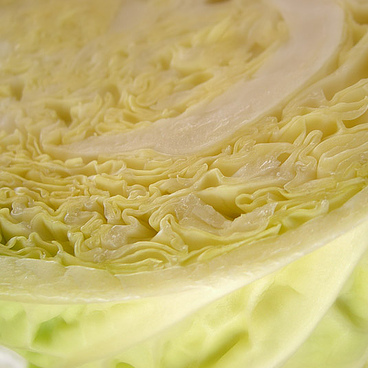

In [85]:
cropped_image

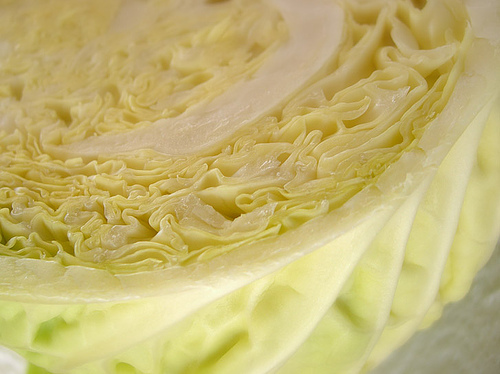

In [86]:
origin_image

In [91]:
print("q_tables",q_tables)
pil_qtables = {}
for idx, q_table in enumerate(q_tables):
    pil_qtables[idx] = zig_zag_flatten(q_table).tolist()
print("pil_qtables",pil_qtables)

q_tables [array([[  5,  52, 128, 177, 194, 212, 221, 231],
       [ 42,  71, 147, 187, 203, 212, 221, 233],
       [ 58, 120, 158, 188, 201, 215, 221, 232],
       [120, 152, 173, 196, 205, 215, 226, 233],
       [161, 172, 186, 198, 206, 218, 224, 236],
       [186, 193, 199, 205, 211, 219, 228, 238],
       [201, 206, 209, 214, 220, 223, 232, 239],
       [218, 221, 222, 222, 227, 233, 239, 244]]), array([[ 19,  97, 175, 206, 222, 231, 238, 244],
       [ 58, 143, 190, 213, 226, 235, 241, 245],
       [127, 175, 197, 217, 228, 237, 243, 246],
       [172, 195, 209, 223, 232, 240, 246, 247],
       [201, 212, 222, 231, 237, 241, 244, 248],
       [218, 224, 231, 238, 240, 246, 247, 249],
       [229, 234, 238, 242, 244, 247, 249, 250],
       [239, 240, 243, 246, 247, 249, 249, 249]]), array([[ 42, 200, 225, 235, 241, 245, 248, 249],
       [180, 214, 229, 236, 245, 246, 248, 249],
       [206, 223, 231, 240, 244, 248, 248, 250],
       [222, 229, 236, 242, 246, 249, 249, 250],
      

5171


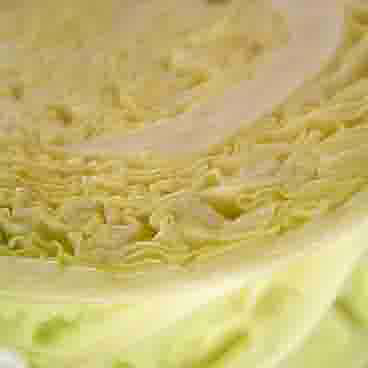

In [93]:
_origin_image = cropped_image

f = BytesIO()
_origin_image.save(f, format='JPEG', qtables=pil_qtables)
deepn_file_size = len(f.getvalue())
print(deepn_file_size)
f.seek(0)
_origin_image_read = Image.open(f)
_origin_image_read

6913


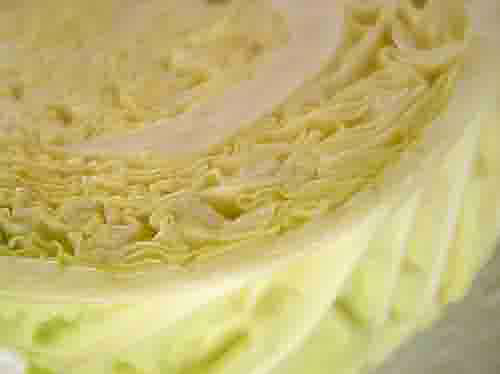

In [92]:
_origin_image = origin_image

f = BytesIO()
_origin_image.save(f, format='JPEG', qtables=pil_qtables)
deepn_file_size = len(f.getvalue())
print(deepn_file_size)
f.seek(0)
_origin_image_read = Image.open(f)
_origin_image_read

(640, 396)
(640, 396)


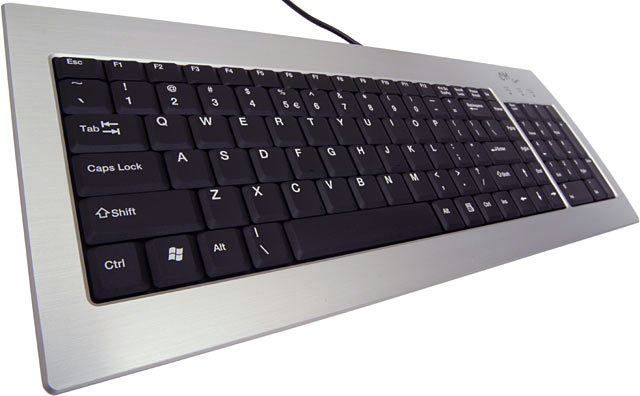

In [218]:
rec_image = Image.merge("YCbCr", channels).convert('RGB')
print(size(rec_image))
print(size(origin_image))
rec_image

7001


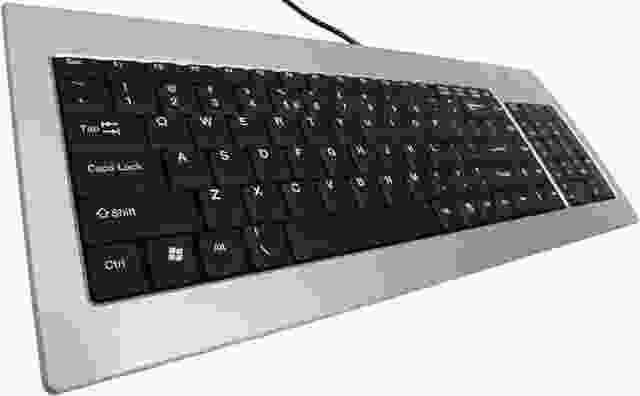

In [236]:
img = Image.open('/home/imagenet-data/train/n03085013/n03085013_2640.JPEG')
f = BytesIO()
img.save(f, format='JPEG', quality=5)
bytes_content = f.getvalue()
origin_file_size = len(bytes_content)
f.seek(0)
img = Image.open(f)
print(origin_file_size)
img

## JPEG manual Q-table test

In [131]:
pil_qtables = {}
for idx, q_table in enumerate(q_tables):
    pil_qtables[idx] = zig_zag_flatten(q_table).tolist()

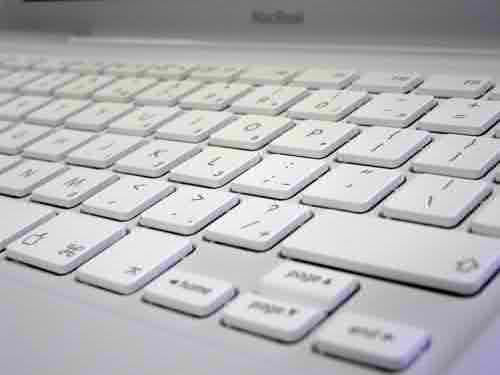

In [132]:
_origin_image = origin_image

f = BytesIO()
_origin_image.save(f, format='JPEG', qtables=pil_qtables)
deepn_file_size = len(f.getvalue())
f.seek(0)
_origin_image_read = Image.open(f)
_origin_image_read

In [133]:
deepn_file_size

13673

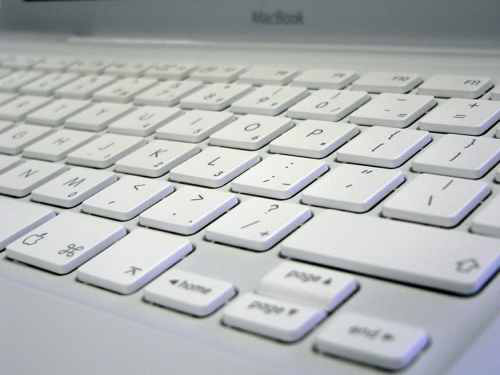

In [151]:
f = BytesIO()
origin_image.save(f, format='JPEG', quality=42)
conventional_file_size = len(f.getvalue())
f.seek(0)
origin_image_read = Image.open(f)
origin_image_read

In [152]:
conventional_file_size

16400

## Model prediction test

In [108]:
from keras.applications import VGG16
from keras.applications.imagenet_utils import preprocess_input
model = VGG16()

  2039808/553467096 [..............................] - ETA: 15:13:14

ConnectionResetError: [Errno 104] Connection reset by peer

In [44]:
image_data = asarray(origin_image_read.resize((224, 224)))
image_data = preprocess_input(image_data)

In [45]:
argmax(model.predict(expand_dims(image_data, axis=0)))

NameError: name 'model' is not defined

# View ground-truth Q-table

## Origin JPEG saving

In [9]:
f1 = BytesIO()
origin_image.save(f1, format='JPEG', quality=50)

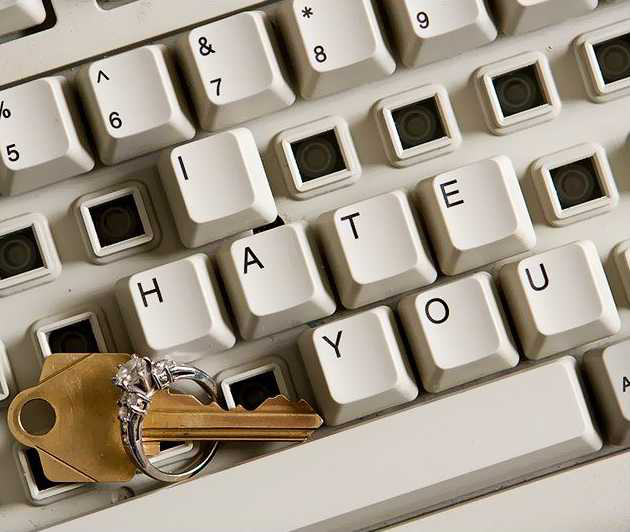

In [10]:
m1 = Image.open(f1)
m1

## Manual q-table JPEG saving

In [11]:
f2 = BytesIO()
man_qtables = {0: [16, 11, 12, 14, 12, 10, 16, 14, 13, 14, 18, 17, 16, 19, 24, 40, 26, 24, 22, 22, 24, 49, 35, 37, 29, 40, 58, 51, 61, 60, 57, 51, 56, 55, 64, 72, 92, 78, 64, 68, 87, 69, 55, 56, 80, 109, 81, 87, 95, 98, 103, 104, 103, 62, 77, 113, 121, 112, 100, 120, 92, 101, 103, 99],
               1: [17, 18, 18, 24, 21, 24, 47, 26, 26, 47, 99, 66, 56, 66, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99],
#                2: [17, 18, 18, 24, 21, 24, 47, 26, 26, 47, 99, 66, 56, 66, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]
              }

origin_image.save(f2, format='JPEG', qtables=man_qtables)

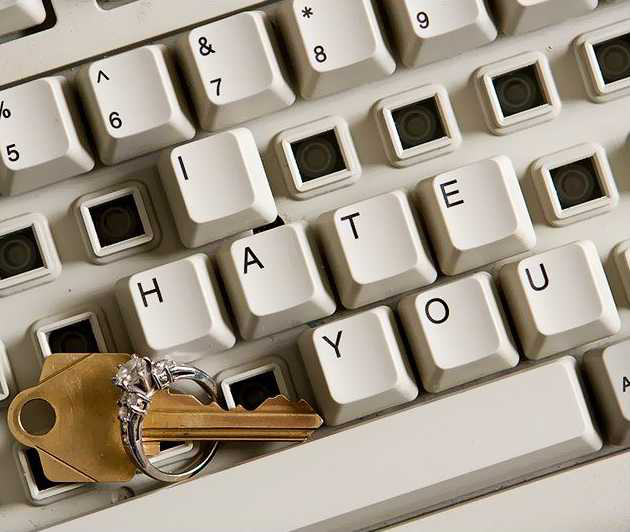

In [12]:
m2 = Image.open(f2)
m2

## Compare

In [13]:
print("Origin size: %s" % len(f1.getvalue()))
print("Manual size: %s" % len(f2.getvalue()))

Origin size: 37953
Manual size: 37953


In [14]:
np.where(m1 != m2)

(array([], dtype=int64),)

## Observe q-tables of different qualities

In [15]:
from mpl_toolkits.mplot3d import Axes3D

In [16]:
def save_with_man_q(image, qtable):
    q_table_pil = {0: qtable.astype(np.uint8).flatten().tolist()}
    fx = BytesIO()
    image.save(fx, format='JPEG', qtables=q_table_pil)
    return Image.open(fx), len(fx.getvalue())

In [17]:
def get_qtable(image, quality):
    fx = BytesIO()
    image.save(fx, format='JPEG', quality=quality)
    qtable = Image.open(fx).quantization
    return array(qtable[0]).reshape((8, 8)), array(qtable[1]).reshape((8, 8))

In [18]:
def display_q_3d(qtable):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    x = array([i for i in range(8)])
    y = array([j for j in range(8)])
    x, y = meshgrid(x, y)
    ax.plot_surface(x, y, qtable)

In [22]:
fig = plt.figure()
for i in arange(20, 50, 2):
    q1, q2 = get_qtable(origin_image, int(i))
    ax = fig.gca(projection='3d')
    x = array([i for i in range(8)])
    y = array([j for j in range(8)])
    x, y = meshgrid(x, y)
    ax.plot_surface(x, y, q1)

In [23]:
q1

array([[ 17,  11,  12,  15,  12,  10,  17,  15],
       [ 14,  15,  19,  18,  17,  20,  25,  42],
       [ 27,  25,  23,  23,  25,  51,  36,  38],
       [ 30,  42,  60,  53,  63,  62,  59,  53],
       [ 58,  57,  67,  75,  96,  81,  67,  71],
       [ 90,  72,  57,  58,  83, 113,  84,  90],
       [ 99, 102, 107, 108, 107,  64,  80, 118],
       [126, 116, 104, 125,  96, 105, 107, 103]], dtype=uint8)

## ImageNet images' quality

In [58]:
ref_qtables = []
for i in arange(1, 101, 1):
    f = BytesIO()
    origin_image.save(f, format='JPEG', quality=int(i))
    ref_qtables.append(Image.open(f).quantization[0])
    
def read_quality(image):
    real_q = image.quantization[0]
    if real_q in ref_qtables:
        return ref_qtables.index(real_q) + 1
    else:
        return 0

In [59]:
def gen_sample_set(father_path, samples_per_class):
    image_paths = []

    img_classes = os.listdir(father_path)
    for img_class in img_classes:
        for image_name in np.random.choice(os.listdir("%s/%s" % (father_path, img_class)), size=samples_per_class):
            sample_image_path = ("%s/%s/%s" % (father_path, img_class, image_name))

            image_paths.append(sample_image_path)
    return image_paths

In [60]:
paths= gen_sample_set('/home/hsli/gnode02/imagenet-data/train/', 20)
imagenet_qualities = []
for path in paths:
    imagenet_qualities.append(read_quality(Image.open(path)))

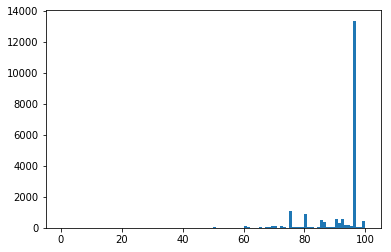

In [61]:
%matplotlib inline
_ = hist(imagenet_qualities, bins=100)

## Get different q-tables

In [24]:
man_q1 = np.ones((8, 8))
for i in range(8):
    for j in range(8):
        man_q1[i,j] = (i+j+1) * 14
man_q1
display_q_3d(man_q1)

In [26]:
rec_img, size = save_with_man_q(origin_image, man_q1)

In [20]:
f = BytesIO()
origin_image.save(f, format='JPEG', quality=10)
Image.open(f).quantization

{0: array('B', [80, 55, 60, 70, 60, 50, 80, 70, 65, 70, 90, 85, 80, 95, 120, 200, 130, 120, 110, 110, 120, 245, 175, 185, 145, 200, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255]),
 1: array('B', [85, 90, 90, 120, 105, 120, 235, 130, 130, 235, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255])}